In [2]:
import torch 
import argparse
import json

import torch
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.transforms import Resize



def preprocess_ect(sample_ect, reference_ect):
    """
    Preprocesses the ECT sets to be compatible with the
    FID, which assumes an image tensor of shape [N,3,299,299]
    with dtype uint 8.
    To that end we resize the ECT and convert to
    """
    t = Resize(299)
    resized_sample_ect = (
        t(255 * sample_ect).to(torch.uint8).unsqueeze(1).repeat(1, 3, 1, 1)
    )
    resized_reference_ect = (
        t(255 * reference_ect).to(torch.uint8).unsqueeze(1).repeat(1, 3, 1, 1)
    )
    return resized_sample_ect, resized_reference_ect


def compute_ect_fid(sample_ect, reference_ect):
    """
    Calculates the FID for two sets of ECTs.
    The ECT tensors are assumed to be of shape [N,3,299,299],
    where N is the number of ECTs with dtype uint
    """
    fid = FrechetInceptionDistance(feature=64)
    fid.update(sample_ect[:300], real=True)
    fid.update(reference_ect[:300], real=False)

    return fid.compute()

In [18]:
# Load samples 
# Load all samples. 
pvd_airplane = torch.load("../results/pvd/airplane/samples.pth").cpu()
ours_airplane = torch.load("../results/vae_airplane_latent/sample_ect.pt")
reference_airplane = torch.load("../results/references/airplane_train_ect.pt")

s = torch.load("../results/encoder_airplane/stdevs.pt").cpu()[:405]
m = torch.load("../results/encoder_airplane/means.pt").cpu()[:405]

print(s.shape)
print(m.shape)
# # # Pass the vae through the train
pvd_airplane = (pvd_airplane -m) / s
pvd_airplane.shape

torch.Size([405, 1, 1])
torch.Size([405, 1, 3])


/tmp/ipykernel_44295/2398179000.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pvd_airplane = torch.load("../results/pvd/airplane/samples.pth").cpu()
/tmp/ipykernel_442

torch.Size([405, 2048, 3])

In [19]:
sample_ect, true_ect = preprocess_ect(ours_airplane,reference_airplane)

In [20]:
compute_ect_fid(sample_ect.cpu(), true_ect.cpu())


tensor(0.1116)

In [21]:
# sample_ect, true_ect = preprocess_ect(pvd_airplane,reference_airplane)
# compute_ect_fid(sample_ect.cpu(), true_ect.cpu())


# PVS

In [22]:
from shapesynthesis.loaders import load_config
from shapesynthesis.layers.ect import compute_ect_point_cloud
from shapesynthesis.layers.directions import generate_uniform_directions

config,_ = load_config("../configs/encoder_airplane.yaml")
ec = config.data.ectconfig

v = generate_uniform_directions(ec.num_thetas,d=ec.ambient_dimension,seed=ec.seed).cuda()

print(v.shape)

result = []
for i in range(0,len(pvd_airplane),16):
    result.append(compute_ect_point_cloud(
        x=pvd_airplane[i:i+16].cuda(),
        v=v,
        radius=ec.r,
        resolution=ec.resolution,
        scale=ec.scale,
    ).cpu())






torch.Size([3, 256])


In [23]:
ect_pvd = torch.cat(result)
ect_pvd.shape

torch.Size([405, 256, 256])

In [24]:
sample_ect, true_ect = preprocess_ect(ect_pvd,reference_airplane)
compute_ect_fid(sample_ect.cpu(), true_ect.cpu())

tensor(89.5549)

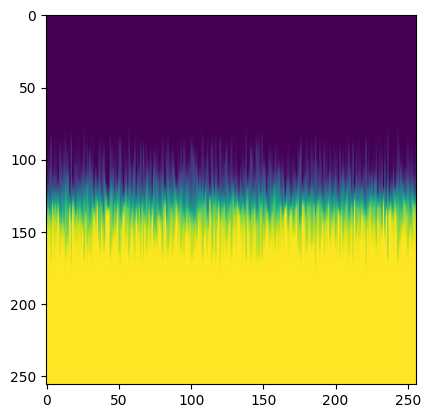

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(ect_pvd[0].cpu())